In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from tqdm import tqdm

# Ideas borrowed from: https://thevatsalsaglani.medium.com/training-and-deploying-a-multi-label-image-classifier-using-pytorch-flask-reactjs-and-firebase-c39c96f9c427 

In [2]:
labels = pd.read_csv("celeba/list_attr_celeba.csv", header=0, index_col=0)
labels.replace(-1, 0, inplace=True)
labels['All'] = labels[labels.columns].values.astype(float).tolist()
labels = pd.DataFrame(labels['All'])
labels.head()

,All
image_id,
000001.jpg,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
000002.jpg,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
000003.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
000004.jpg,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
000005.jpg,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [3]:
random.seed(430)
n = labels.shape[0]
m = round(n*0.8)
train_ind = random.sample(range(n), m)
train = labels.iloc[train_ind]
test = labels.drop(labels.index[train_ind])

In [4]:
class CelebA(Dataset):
    
    def __init__(self, dataframe, data_path, transform = None):
        
        self.dataframe = dataframe
        self.data_path = data_path
        self.transform = transform
        self.file_names = dataframe.index
        self.labels = dataframe.All.values.tolist()        
        
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, index):
        
        image = Image.open(os.path.join(self.data_path, self.file_names[index]))
        label = np.array(self.labels[index])
        sample = {'image': image, 'label': label}
        if self.transform:
            image = self.transform(sample['image'])
            sample = {'image': image, 'label': label}
        
        return sample

In [5]:
transform = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
train_dl = CelebA(train, 'celeba/img_align_celeba/img_align_celeba/', transform = transform)
test_dl = CelebA(test, 'celeba/img_align_celeba/img_align_celeba/', transform = transform)

In [6]:
# Detect if a GPU is present with CUDA support
use_cuda = torch.cuda.is_available()

# Set a seed for reproducibility
torch.manual_seed(430)

# Configure low-level options
device = torch.device("cuda" if use_cuda else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


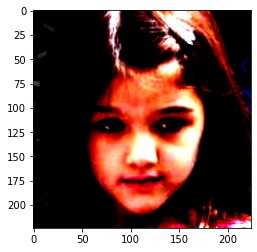

In [7]:
plt.imshow(torchvision.utils.make_grid(train_dl[0]['image']).permute(1, 2, 0))
plt.show()

In [8]:
train_dl[0]['label']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1.])

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.Conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), 
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,stride=2), 
            nn.ReLU(), 
        )
        self.Conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,stride=2), 
            nn.ReLU() 
        )
        self.Conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), 
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,stride=2), 
            nn.ReLU()
        )
        self.Conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1), 
            nn.BatchNorm2d(512),
            nn.AvgPool2d(2,stride=2), 
            nn.ReLU(), 
            nn.Dropout(0.1) 
        )
        self.Conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1), 
            nn.BatchNorm2d(1024),
            nn.AvgPool2d(2,stride=2), 
            nn.ReLU(), 
            nn.Dropout(0.25) 
        )

        self.Linear1 = nn.Linear(1024 * 7 * 7, 2048)
        self.Linear2 = nn.Linear(2048, 256)
        self.Linear3 = nn.Linear(256, 40)
        self.float()
        
    def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x = self.Conv5(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        return torch.sigmoid(x)

In [10]:
model = CNN().to(device)

In [11]:
model.eval()

CNN(
  (Conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (Conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (Conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (Conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm

In [12]:
train_dataloader = DataLoader(train_dl, shuffle = True, batch_size = 128)
test_dataloader = DataLoader(test_dl, shuffle = True, batch_size = 128)

In [13]:
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

In [14]:
bce = nn.BCELoss()
writer = SummaryWriter()

def train(model, device, train_loader, optimizer, epoch):
    # Set model to training mode
    model.train()
    train_loss = 0
    
    # Perform batch training
    for batch_idx, face in enumerate(train_loader):
        # Load data on device
        data, target = face['image'].to(device), face['label'].float().to(device)
        data, target = Variable(data), Variable(target)

        # Zero the gradient buffers
        optimizer.zero_grad()

        # Compute prediction
        output = model(data)

        # Calculate the loss
        loss = bce(output, target)
        train_loss += loss

        # Write result to visualize with tensorboard
        writer.add_scalar("Loss/train", loss, epoch)

        # Perform backward propagation
        loss.backward()

        # Update weight parameters
        optimizer.step()

        # Show progress
        if batch_idx % 250 == 0:
            print(f'Train Epoch: {epoch}',
                  f' [{batch_idx * len(data)}/{len(train_loader.dataset)}',
                  f'({100. * batch_idx / len(train_loader):.0f}%)]',
                  f'\tLoss: {loss.item():.6f}')
    
    train_loss_history.append(train_loss.item())

In [15]:
def test(model, device, test_loader):
    
    # Set model to evaluation mode
    model.eval()

    # Initialize variables
    test_loss = 0
    correct = []

    # Perform computation with gradient disabled
    with torch.no_grad():
        for batch_idx, face in enumerate(test_loader):
            # Load data on device
            data, target = face['image'].to(device), face['label'].float().to(device)
            data, target = Variable(data), Variable(target)

            # Feed the network test data
            output = model(data)
            
            accuracy = []

            for i, d in enumerate(output, 0):
                ytrue = torch.Tensor.cpu(target[i])
                #d = torch.sigmoid(d)
                ypred = torch.Tensor.cpu(d)
                acc = torch.round(ypred).eq(ytrue).numpy().tolist()
                accuracy.append(acc)
            correct.append(np.sum(accuracy, axis=0).tolist())
            
            # Compute testing loss
            test_loss += bce(output, target)
           
    
    # average accuracy for each label
    accur = np.sum(correct, axis=0)/len(test_loader.dataset)

    print(f'\nTesting average loss: {test_loss:.4f}',
          f'Overall accuracy: {accur.mean():.4f}', 
          f'Accuracy for each label: {np.round(accur, 4)}\n')
    
    test_loss_history.append(test_loss.item())
    test_accuracy_history.append(accur.mean())

In [16]:
# Set number of training epochs
n_epochs = 15

# Setup learning rate decay

optimizer = optim.Adam(model.parameters(), lr = 0.0002)

model = model.to(device)

# Train model over N_epochs
for epoch in range(1, n_epochs + 1):
    # Perform training routine
    train(model, device, train_dataloader, optimizer, epoch)

    # Perform validating routine
    test(model, device, test_dataloader)

    # Decay learning rate
    optimizer.step()

Train Epoch: 1  [0/162079 (0%)] 	Loss: 0.692012
Train Epoch: 1  [32000/162079 (20%)] 	Loss: 0.250201
Train Epoch: 1  [64000/162079 (39%)] 	Loss: 0.231021
Train Epoch: 1  [96000/162079 (59%)] 	Loss: 0.200676
Train Epoch: 1  [128000/162079 (79%)] 	Loss: 0.220797
Train Epoch: 1  [160000/162079 (99%)] 	Loss: 0.208378

Testing average loss: 69.8556 Overall accuracy: 0.9038 Accuracy for each label: [0.9307 0.8112 0.8128 0.841  0.9865 0.9301 0.7762 0.83   0.8913 0.9517
 0.9612 0.859  0.9128 0.9467 0.9571 0.994  0.9622 0.9782 0.9122 0.872
 0.9731 0.9335 0.9629 0.8846 0.9375 0.7421 0.9591 0.7611 0.9322 0.9519
 0.9661 0.9253 0.8115 0.8002 0.8904 0.9866 0.9206 0.8778 0.9433 0.874 ]

Train Epoch: 2  [0/162079 (0%)] 	Loss: 0.209605
Train Epoch: 2  [32000/162079 (20%)] 	Loss: 0.195459
Train Epoch: 2  [64000/162079 (39%)] 	Loss: 0.207750
Train Epoch: 2  [96000/162079 (59%)] 	Loss: 0.205012
Train Epoch: 2  [128000/162079 (79%)] 	Loss: 0.199749
Train Epoch: 2  [160000/162079 (99%)] 	Loss: 0.196207

Tes

Train Epoch: 13  [0/162079 (0%)] 	Loss: 0.108625
Train Epoch: 13  [32000/162079 (20%)] 	Loss: 0.108067
Train Epoch: 13  [64000/162079 (39%)] 	Loss: 0.117579
Train Epoch: 13  [96000/162079 (59%)] 	Loss: 0.121497
Train Epoch: 13  [128000/162079 (79%)] 	Loss: 0.128011
Train Epoch: 13  [160000/162079 (99%)] 	Loss: 0.131413

Testing average loss: 69.4030 Overall accuracy: 0.9124 Accuracy for each label: [0.9388 0.846  0.821  0.8498 0.9897 0.9553 0.7826 0.8465 0.8926 0.9525
 0.9615 0.8639 0.9172 0.9556 0.9635 0.9952 0.9672 0.9789 0.9184 0.8747
 0.9825 0.9312 0.9691 0.8978 0.9548 0.7687 0.9657 0.7589 0.941  0.9485
 0.9755 0.924  0.8275 0.8392 0.9029 0.9892 0.9313 0.8773 0.9498 0.8886]

Train Epoch: 14  [0/162079 (0%)] 	Loss: 0.104855
Train Epoch: 14  [32000/162079 (20%)] 	Loss: 0.104362
Train Epoch: 14  [64000/162079 (39%)] 	Loss: 0.115369
Train Epoch: 14  [96000/162079 (59%)] 	Loss: 0.110990
Train Epoch: 14  [128000/162079 (79%)] 	Loss: 0.111796
Train Epoch: 14  [160000/162079 (99%)] 	Loss: 

In [17]:
pd.DataFrame(train_loss_history).to_csv('CNN_train_loss_history.csv')

In [18]:
pd.DataFrame(test_loss_history).to_csv('CNN_test_loss_history.csv')

In [19]:
pd.DataFrame(test_accuracy_history).to_csv('CNN_test_accuracy_history.csv')

In [20]:
torch.save(model, 'CelebA_CNN.pth')

In [21]:
%load_ext tensorboard

In [22]:
%tensorboard --logdir runs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 305697.